# Word Embeddings

- The state-of-art way of vectorizing texts is to learn the numeric representations of words based on deep learning methods.
- These deep-learning based numeric representations of linguistic units are commonly referred to as **embeddings**.
- Word embeddings can be learned either along with the targe NLP task (e.g., the `Embedding` layer in RNN Language Model) or via an **unsupervised** method based on a large number of texts.
- In this tutorial, we will look at two main algorithms in **word2vec** that allow us to learn the word embeddings in an unsupervised manner from a large collection of texts.

- Strengths of word embeddings
    - They can be learned using unsupervised methods.
    - They include quite a proportion of the lexical semantics.
    - They can be learned by batch. We don't have to process the entire corpus and create the word-by-document matrix for embeddings learning. Therefore, it is less likely to run into the memory capacity issue for huge corpora.

## Overview

### What is `word2vec`?

- `Word2vec` is one of the most popular techniques to learn word embeddings using a two-layer neural network.
- The input is a text corpus and the output is a set of word vectors.
- Research has shown that these embeddings include rich semantic information of words, which allow us to perform interesting semantic computation.

### Main training algorithms of `word2vec`

- Continuous bag-of-words (**CBOW**): The general language modeling task for embeddings training is to learn a model that is capable of using the context words to predict a target word.
- **Skip-gram**: The general language modeling task for embeddings training is to learn a model that is capable of using a word to predict its target context words.

![](../images/word2vec.png)

- Other variants of embeddings training:
  - `fasttext` from Facebook
  - `GloVe` from Stanford NLP Group (?)
- There are many ways to train work embeddings.
  - `gensim`: Simplest and straightforward implementation of `word2vec`.
  - Training based on deep learning packages (e.g., `keras`, `tensorflow`)
  - `spacy` (It comes with the pre-trained embeddings models.)

### An Intuitive Understanding of CBOW

![](../images/word2vec-text-to-sequences.gif)

![](../images/word2vec-cbow.gif)

### An Intuitive Understanding of Skip-gram

![](../images/word2vec-skipgram.gif)

## Import necessary dependencies and settings

In [44]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200

In [3]:
# # Google Colab Adhoc Setting
# !nvidia-smi
# nltk.download(['gutenberg','punkt','stopwords'])
# !pip show spacy
# !pip install --upgrade spacy
# #!python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_lg

## Sample Corpus: A Naive Example

In [4]:
corpus = [
    'The sky is blue and beautiful.', 'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]
labels = [
    'weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather',
    'animals'
]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple text pre-processing

- Usually for unsupervised `word2vec` learning, we don't really need much text processing.
- So we keep our preprocessing to the minimum.
    - Remove only symbols/punctuations, as well as redundant whitespaces.
    - Perform word tokenization, which would also determine the base units for embeddings learning.

In [58]:
wpt = nltk.WordPunctTokenizer()
# stop_words = nltk.corpus.stopwords.words('english')


def preprocess_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    doc = ' '.join(tokens)
    return doc

corpus_norm = [preprocess_document(text) for text in corpus]
corpus_tokens = [preprocess_document(text).split(' ') for text in corpus]

In [60]:
print(corpus_norm)
print(corpus_tokens)

['the sky is blue and beautiful', 'love this blue and beautiful sky', 'the quick brown fox jumps over the lazy dog', 'a kings breakfast has sausages ham bacon eggs toast and beans', 'i love green eggs ham sausages and bacon', 'the brown fox is quick and the blue dog is lazy', 'the sky is very blue and the sky is very beautiful today', 'the dog is lazy but the brown fox is quick']
[['the', 'sky', 'is', 'blue', 'and', 'beautiful'], ['love', 'this', 'blue', 'and', 'beautiful', 'sky'], ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'], ['a', 'kings', 'breakfast', 'has', 'sausages', 'ham', 'bacon', 'eggs', 'toast', 'and', 'beans'], ['i', 'love', 'green', 'eggs', 'ham', 'sausages', 'and', 'bacon'], ['the', 'brown', 'fox', 'is', 'quick', 'and', 'the', 'blue', 'dog', 'is', 'lazy'], ['the', 'sky', 'is', 'very', 'blue', 'and', 'the', 'sky', 'is', 'very', 'beautiful', 'today'], ['the', 'dog', 'is', 'lazy', 'but', 'the', 'brown', 'fox', 'is', 'quick']]


### Training Embeddings Using word2vec

- The expected inputs of `gensim.model.word2vec` is token-based corpus object.

In [12]:
%%time

from gensim.models import word2vec

# Set values for various parameters
feature_size = 10  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 1  # Minimum word count
sample = 1e-3  # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(
    corpus_tokens,
    size=feature_size,
    window=window_context,
    min_count=min_word_count,
    sg=0,  # `1` for skip-gram; otherwise CBOW.
    sample=sample,
    iter=100)

CPU times: user 81.5 ms, sys: 24.4 ms, total: 106 ms
Wall time: 103 ms


### Visualizing Word Embeddings

- Embeddings represent words in multidimensional space.
- We can inspect the quality of embeddings using dimensional reduction and visualize words in a 2D plot.

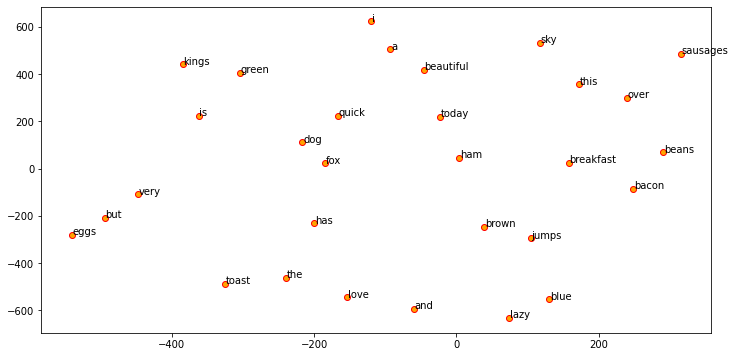

In [19]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

- Word Embeddings are included as a dictionary in `w2v_model.wv`.
- We can thererfore easily extract embeddings for any specific words.

In [8]:
w2v_model.wv['sky']

array([ 0.04913035, -0.04127565, -0.02100882, -0.04237808, -0.03005596,
        0.00605162,  0.02097021, -0.03607806, -0.03568011, -0.03890556],
      dtype=float32)

### From Word Embeddings to Document Embeddings

- With word embeddings, we can compute the average word embeddings for the entire text to get the "document" embeddings.
- These document embeddings are also assumed to have included considerable semantic information of the document.
- We can for example use them to document clustering.

In [26]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features, ), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [
        average_word_vectors(tokenized_sentence, model, vocabulary,
                             num_features) for tokenized_sentence in corpus
    ]
    return np.array(features)

In [61]:
w2v_feature_array = averaged_word_vectorizer(corpus=corpus_tokens,
                                             model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array, index=corpus_norm)

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
the sky is blue and beautiful,-0.001060,-0.015467,-0.014791,0.004115,-0.020031,-0.003055,-0.009941,0.010358,0.001330,0.017331
love this blue and beautiful sky,-0.009581,-0.008112,-0.019936,0.003655,-0.019663,-0.007183,-0.013381,0.015408,-0.003885,0.025851
the quick brown fox jumps over the lazy dog,0.004297,-0.020559,0.004206,-0.016876,-0.003749,0.005487,-0.007146,0.024569,-0.011903,0.010247
a kings breakfast has sausages ham bacon eggs toast and beans,0.018964,-0.016484,-0.006553,0.008626,-0.003162,0.002099,-0.005488,0.035315,0.009895,0.002971
i love green eggs ham sausages and bacon,0.012832,-0.018928,-0.013178,0.010925,-0.018657,0.004540,-0.009535,0.027428,0.003579,0.007454
the brown fox is quick and the blue dog is lazy,0.006611,-0.030290,0.005556,-0.008672,-0.016297,-0.002592,-0.004292,0.014799,-0.006948,0.007406
the sky is very blue and the sky is very beautiful today,0.011354,-0.015755,-0.014526,0.005151,-0.011789,-0.002460,-0.011650,0.009205,0.001669,0.007012
the dog is lazy but the brown fox is quick,0.015566,-0.026750,0.008032,-0.007027,-0.010586,-0.003152,-0.004341,0.021150,-0.005376,0.003856


- Let's cluster these documents based on their document embeddings

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

similarity_doc_matrix = cosine_similarity(w2v_feature_array)
similarity_doc_df = pd.DataFrame(similarity_doc_matrix)
similarity_doc_df

,0,1,2,3,4,5,6,7
0,1.000000,0.931563,0.473875,0.525375,0.813883,0.648699,0.871993,0.514486
1,0.931563,1.000000,0.423939,0.384280,0.664568,0.469317,0.711736,0.325903
2,0.473875,0.423939,1.000000,0.572424,0.571366,0.843252,0.467117,0.852239
3,0.525375,0.384280,0.572424,1.000000,0.887566,0.557552,0.720874,0.720873
4,0.813883,0.664568,0.571366,0.887566,1.000000,0.671229,0.898897,0.707836
5,0.648699,0.469317,0.843252,0.557552,0.671229,1.000000,0.646984,0.943901
6,0.871993,0.711736,0.467117,0.720874,0.898897,0.646984,1.000000,0.634365
7,0.514486,0.325903,0.852239,0.720873,0.707836,0.943901,0.634365,1.000000


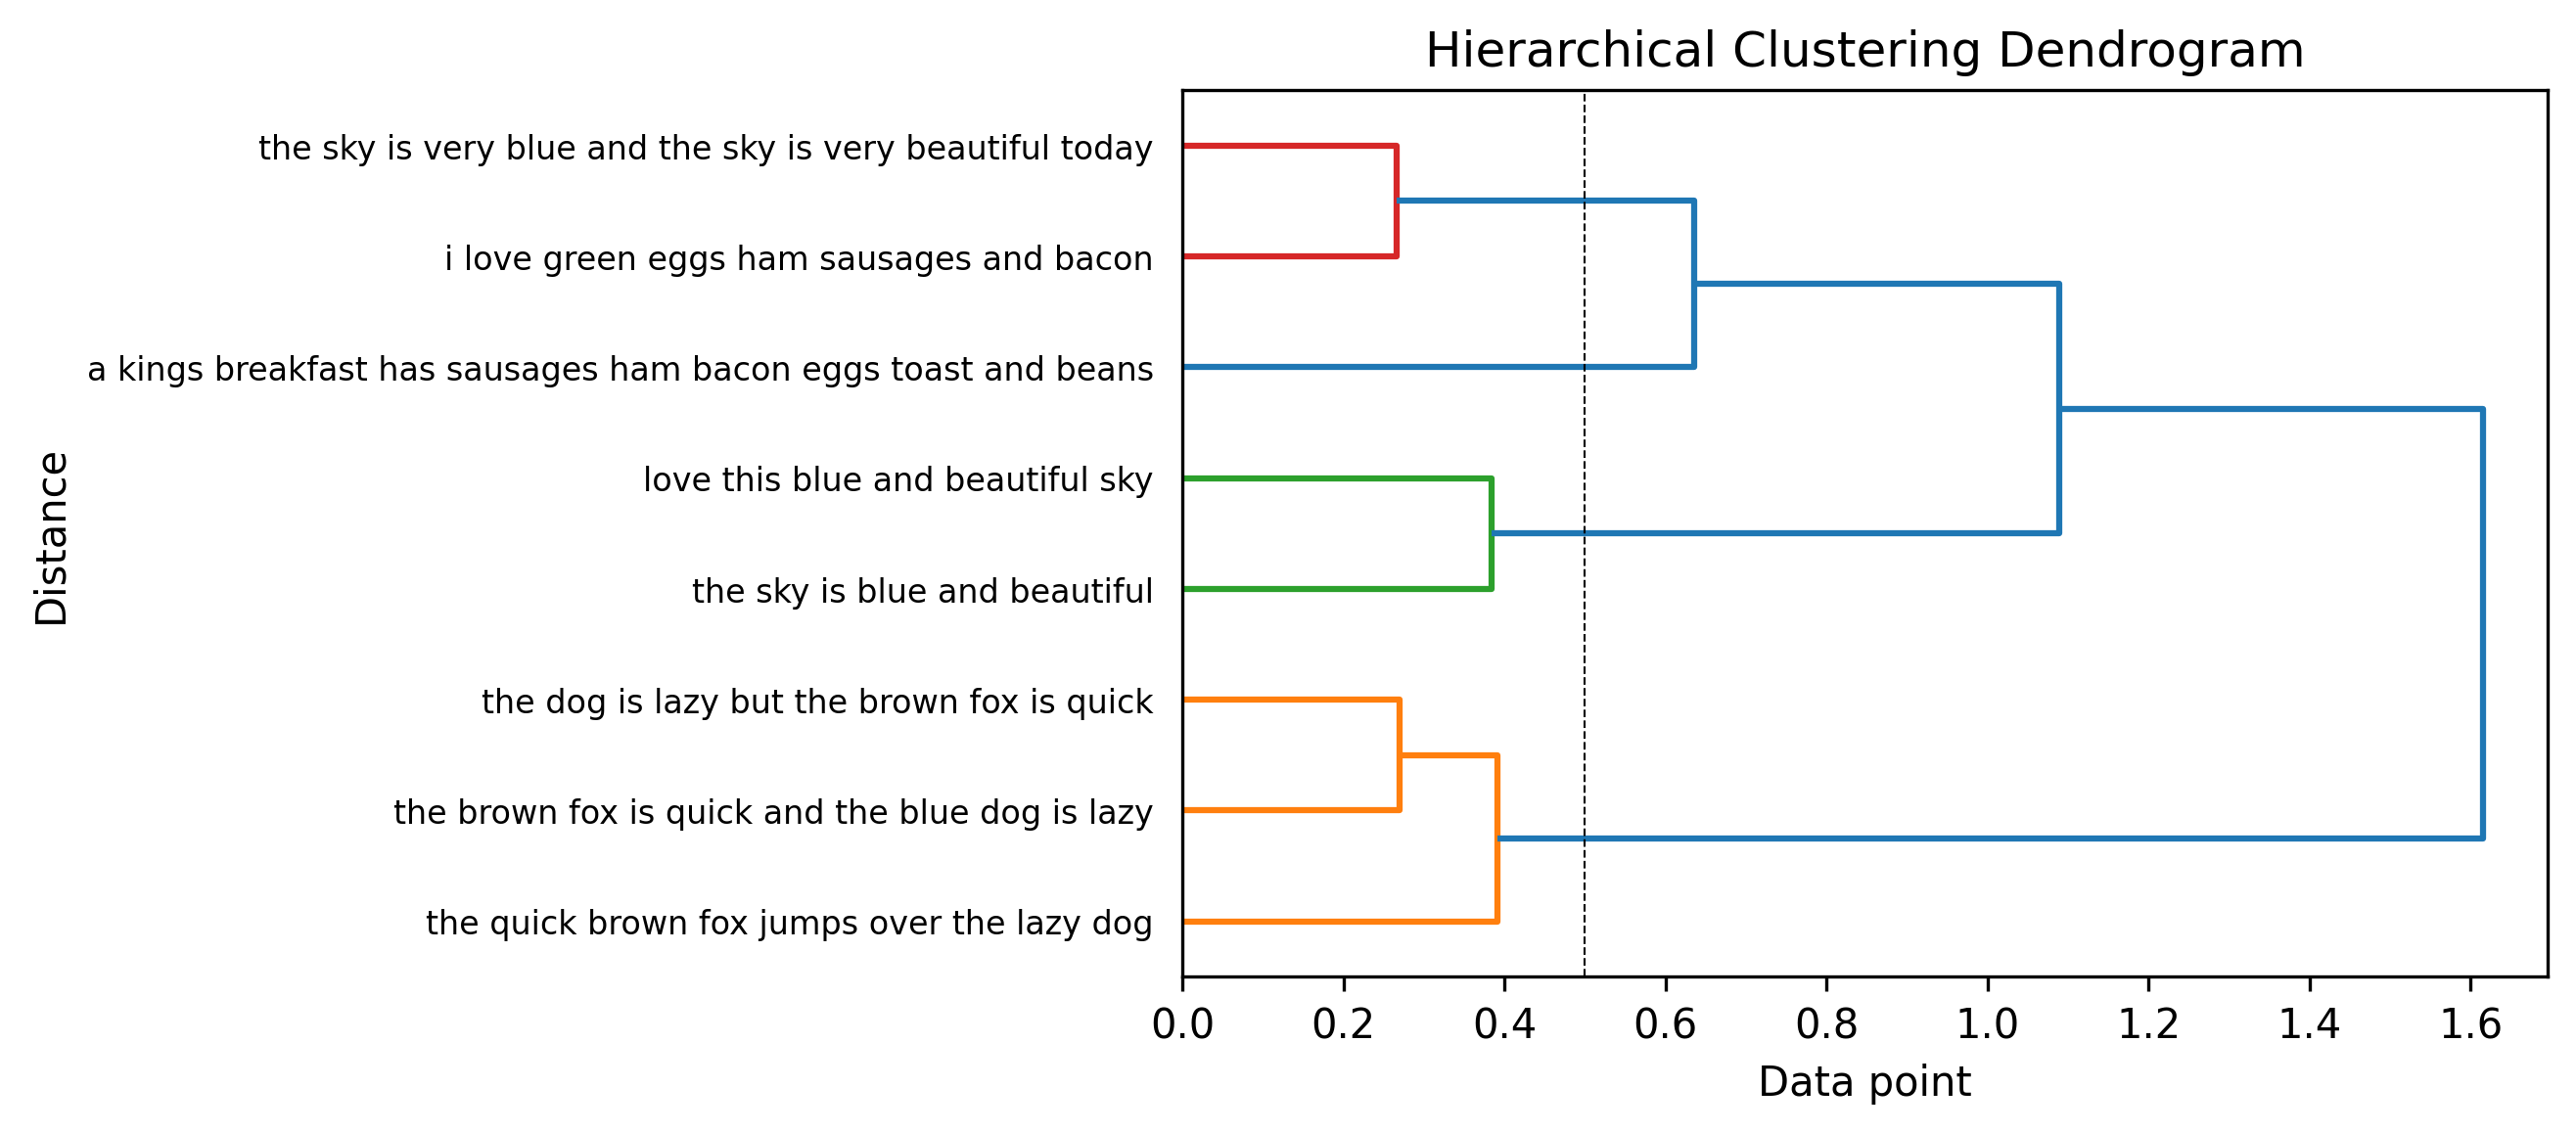

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_doc_matrix, 'ward')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z,
           labels=corpus_norm,
           leaf_rotation=0,
           leaf_font_size=8,
           orientation='right',
           color_threshold=0.5)
plt.axvline(x=0.5, c='k', ls='--', lw=0.5)

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


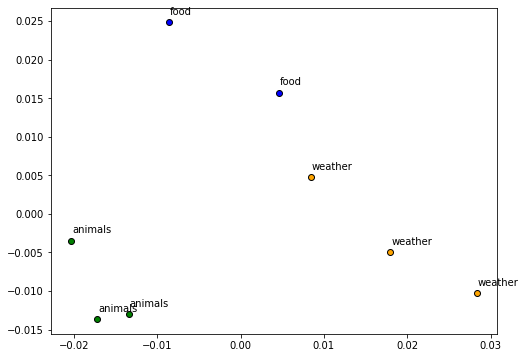

In [42]:
## Other Clustering Methods

from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

## PCA Plotting
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label,
                 xy=(x + 1e-4, y + 1e-3),
                 xytext=(0, 0),
                 textcoords='offset points')

## Using Pre-trained Embeddings:  GloVe in `spacy`

In [51]:
import spacy


nlp = spacy.load('en_core_web_lg',disable=['parse','entity'])

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 684830


In [52]:
print(spacy.__version__)

3.0.5


### Visualize GloVe word embeddings

- Let's extract the GloVe embeddings of the words in our simple corpus.

:::{warning}
When using pre-trained embeddings, there are two important things:
- Be very careful of the tokenization methods used in your text preprocessing. If you use a very different word tokenization method, you may find a lot of unknown words that are not included in the pretrained model.
- Always check the proportion of the unknown words when vectorizing your corpus texts with pre-trained embeddings.
:::

In [87]:
# get vocab of the corpus
unique_words = set(sum(corpus_tokens,[]))

# extract pre-trained embeddings of all words
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
very,-0.313420,0.372670,-0.416000,0.185190,0.084357,0.053412,0.253420,-0.442260,-0.108610,2.46910,...,-0.374230,0.056770,0.018460,0.002891,0.515560,0.297570,0.334740,-0.308780,0.126210,0.130530
green,-0.072368,0.233200,0.137260,-0.156630,0.248440,0.349870,-0.241700,-0.091426,-0.530150,1.34130,...,-0.405170,0.243570,0.437300,-0.461520,-0.352710,0.336250,0.069899,-0.111550,0.532930,0.712680
toast,0.130740,-0.193730,0.253270,0.090102,-0.272580,-0.030571,0.096945,-0.115060,0.484000,0.84838,...,0.142080,0.481910,0.045167,0.057151,-0.149520,-0.495130,-0.086677,-0.569040,-0.359290,0.097443
dog,-0.401760,0.370570,0.021281,-0.341250,0.049538,0.294400,-0.173760,-0.279820,0.067622,2.16930,...,0.022908,-0.259290,-0.308620,0.001754,-0.189620,0.547890,0.311940,0.246930,0.299290,-0.074861
i,0.187330,0.405950,-0.511740,-0.554820,0.039716,0.128870,0.451370,-0.591490,0.155910,1.51370,...,0.116330,0.079300,-0.391420,-0.324830,0.634510,-0.189100,0.054050,0.164950,0.187570,0.538740
quick,-0.445630,0.191510,-0.249210,0.465900,0.161950,0.212780,-0.046480,0.021170,0.417660,1.68690,...,-0.329460,0.421860,-0.039543,0.150180,0.338220,0.049554,0.149420,-0.038789,-0.019069,0.348650
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.60343,...,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
this,-0.087595,0.355020,0.063868,0.292920,-0.236350,-0.062773,-0.161050,-0.228420,0.041587,2.48440,...,-0.039495,0.093723,0.093557,-0.097551,0.306390,-0.273250,-0.331120,0.034460,-0.150270,0.406730
kings,0.259230,-0.854690,0.360010,-0.642000,0.568530,-0.321420,0.173250,0.133030,-0.089720,1.52860,...,-0.470090,0.063743,-0.545210,-0.192310,-0.301020,1.068500,0.231160,-0.147330,0.662490,-0.577420
love,0.139490,0.534530,-0.252470,-0.125650,0.048748,0.152440,0.199060,-0.065970,0.128830,2.05590,...,-0.124380,0.178440,-0.099469,0.008682,0.089213,-0.075513,-0.049069,-0.015228,0.088408,0.302170


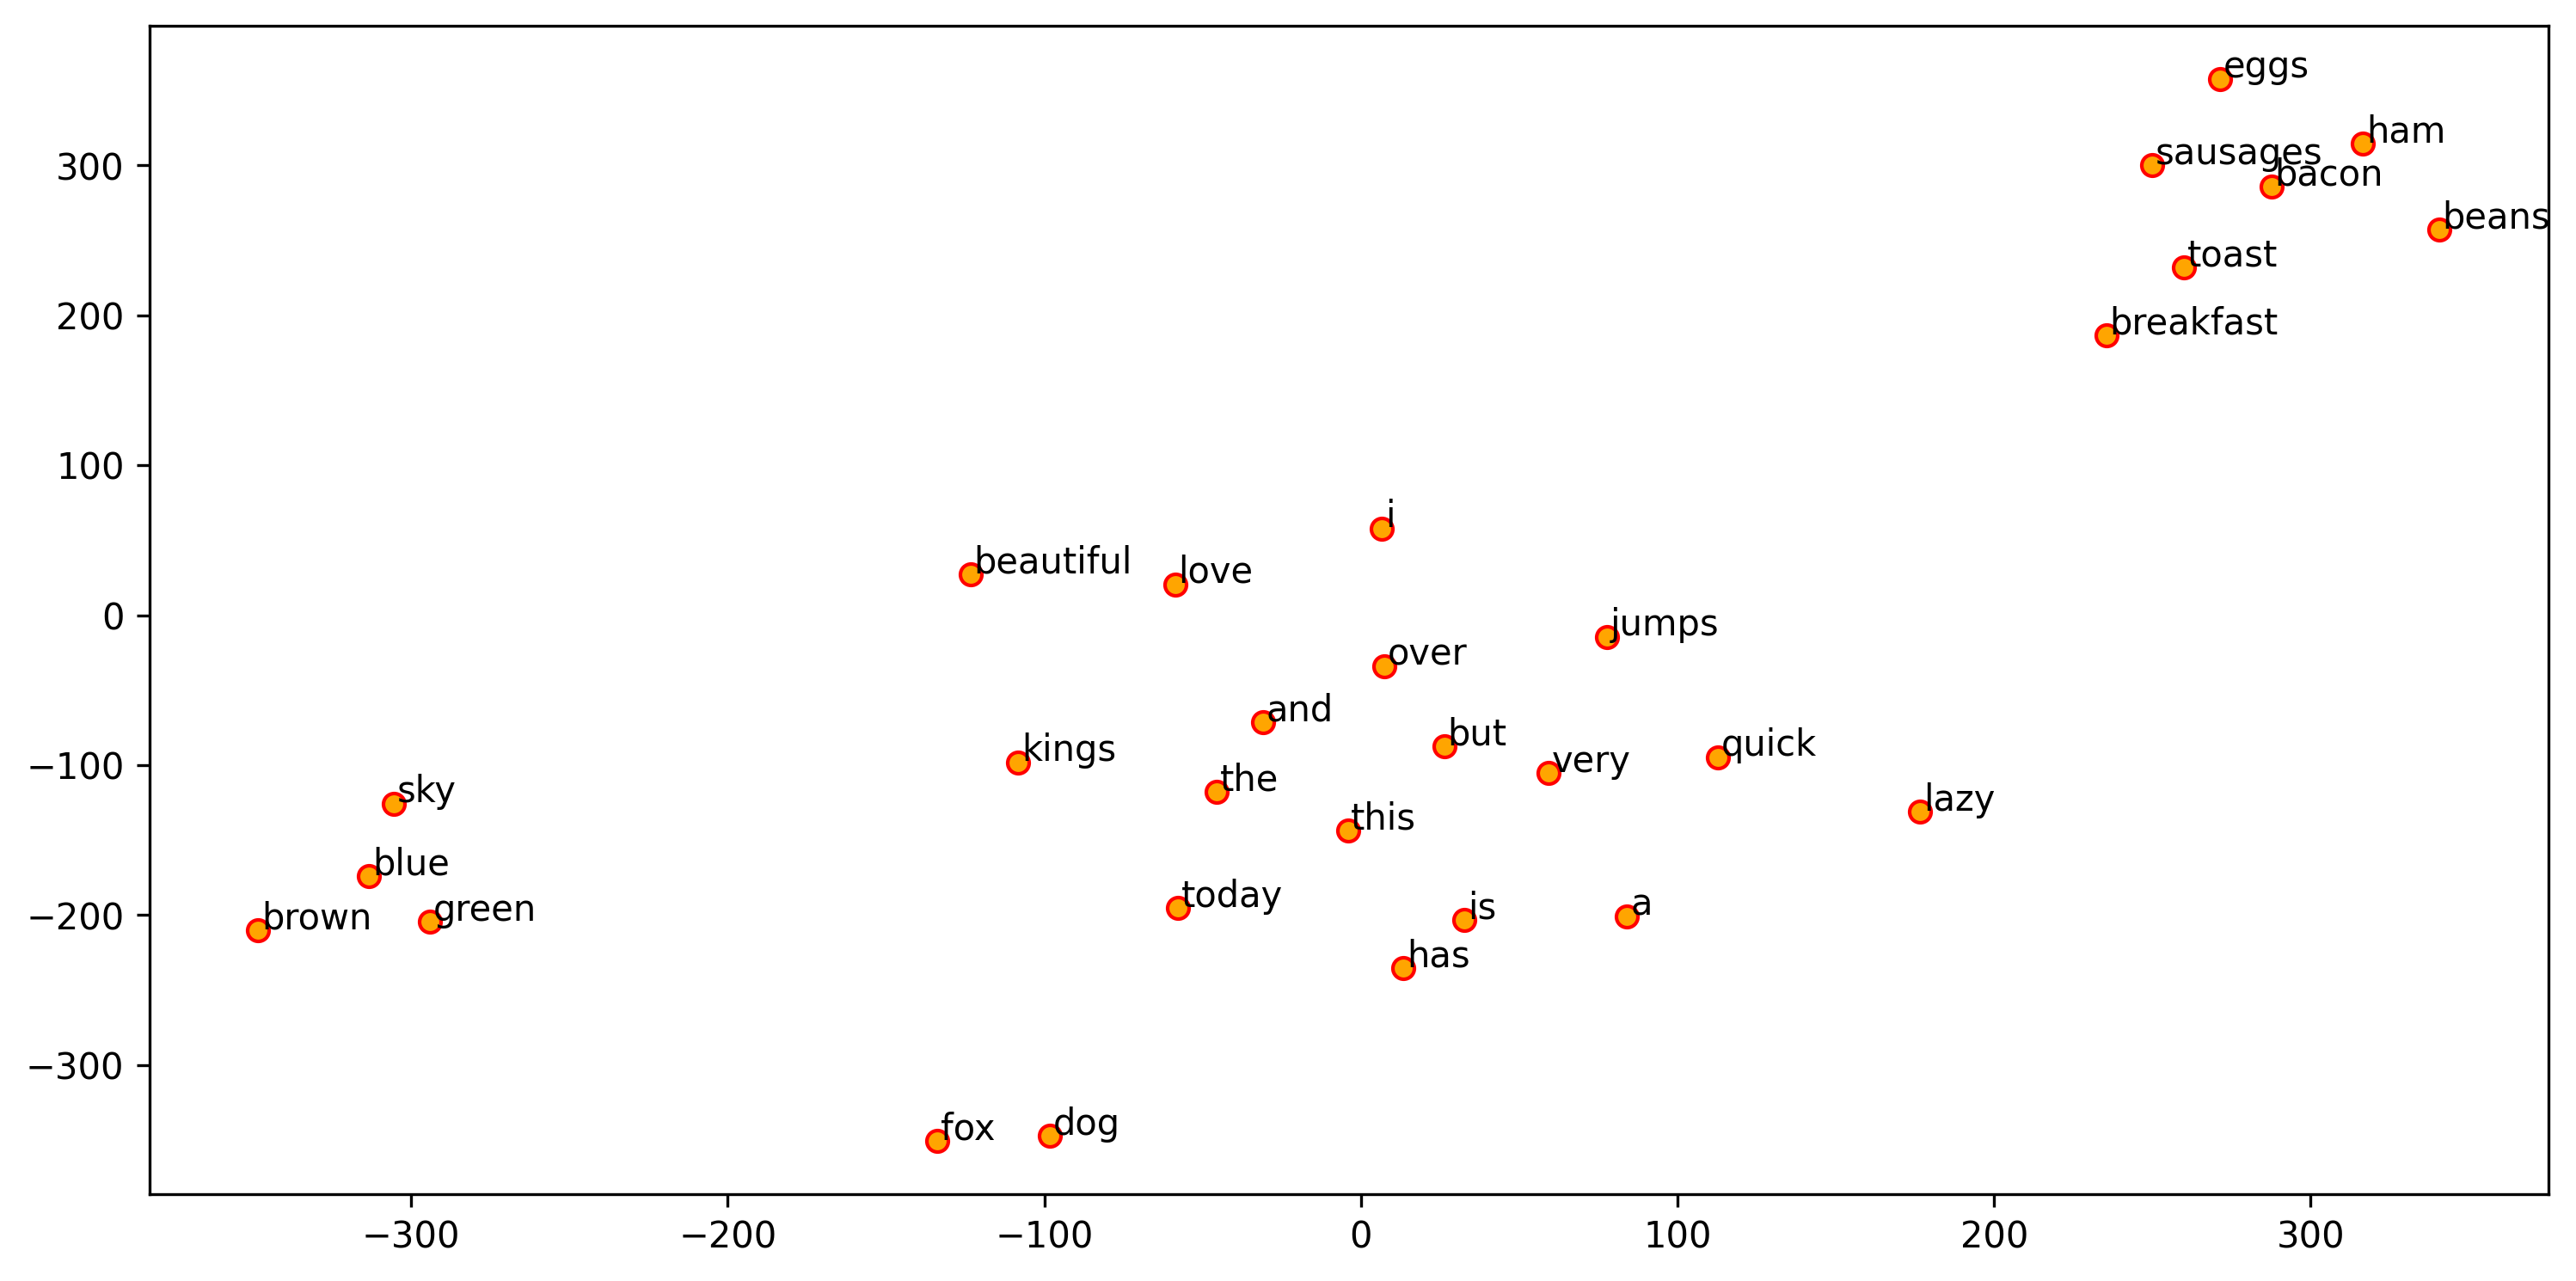

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
    

- It is clear to see that when embeddings are trained based on a larger corpus, they reflect more lexical semantic contents.

- We can of course perform the document-level clustering again using the GloVe embeddings.
- The good thing about `spacy` is that it can compute the document average embeddings automatically.

In [63]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in corpus_norm])

import sklearn
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


## `fasttext`

- This section shows a quick example how to train word embeddings based on the `nltk.corpus.brown` using another algorithm, i.e., `fasttext`.

In [65]:
from gensim.models.fasttext import FastText
from nltk.corpus import brown

brown_tokens = [brown.words(fileids=f) for f in brown.fileids()]

CPU times: user 21.2 ms, sys: 19.8 ms, total: 40.9 ms
Wall time: 578 ms


In [67]:
%%time
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count
sample = 1e-3  # Downsample setting for frequent words

ft_model = FastText(brown_tokens,
                    size=feature_size,
                    window=window_context,
                    min_count=min_word_count,
                    sample=sample,
                    sg=1,
                    iter=50)

CPU times: user 12min 1s, sys: 26.3 s, total: 12min 28s
Wall time: 5min 8s


In [83]:
# view similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
    for search_term in
    ['think', 'say','news', 'report','nation', 'democracy']
}
similar_words

{'think': ['know', 'say', 'Think', 'tell', 'believe'],
 'say': ['think', 'know', 'pretend', 'believe', 'do'],
 'news': ['News', 'reportedly', 'forthcoming', 'newspaper', 'newspapers'],
 'report': ['reports',
  'reporting',
  'Investigation',
  'recommending',
  "Department's"],
 'nation': ['nations', 'national', 'nationally', "nation's", 'nation-state'],
 'democracy': ['democratic', 'legacy', 'bureaucracy', 'cultural', 'Western']}

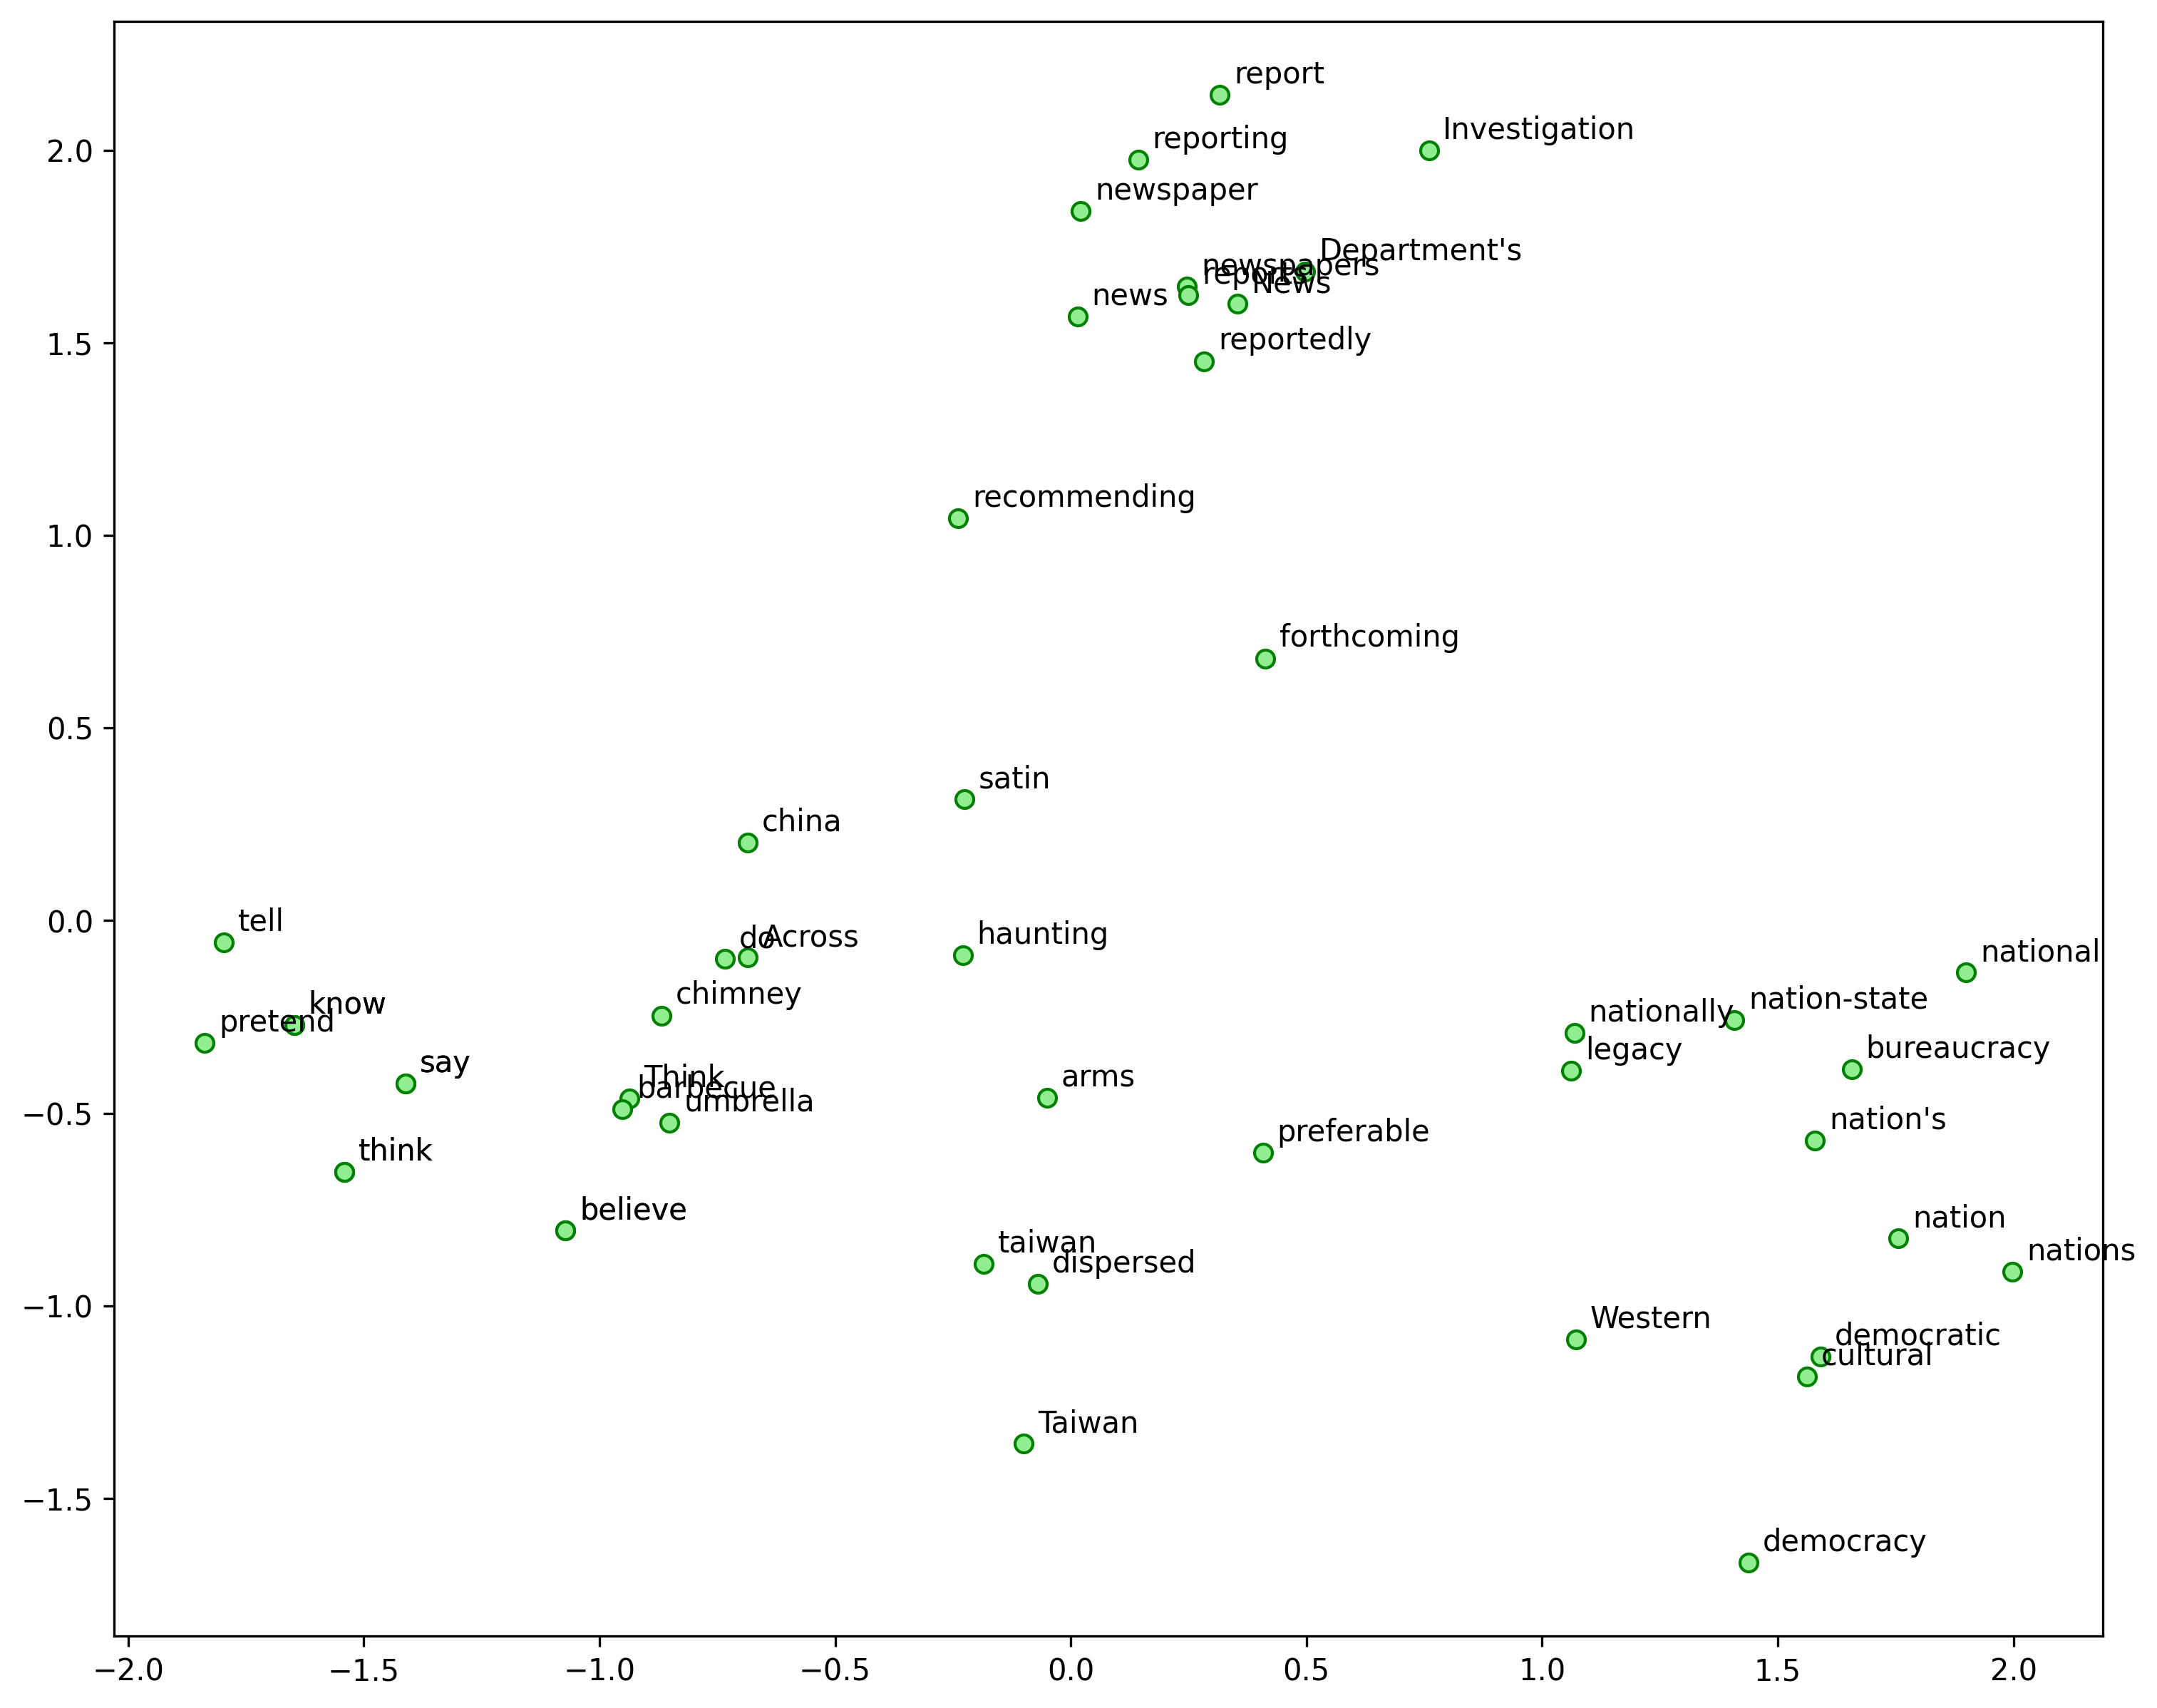

In [82]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.03, y + 0.03),
                 xytext=(0, 0),
                 textcoords='offset points')

In [75]:
ft_model.wv['democracy']

array([ 0.64609605, -0.64112324,  0.2841256 , -0.2121601 , -0.34143615,
       -0.6647942 ,  0.30566752, -0.243561  ,  0.10510016,  0.0845444 ,
       -0.46348095, -0.48548022,  0.18196762, -0.36037102, -0.4367724 ,
        0.04781468, -0.2495322 , -0.21753973,  0.4549447 , -0.493087  ,
       -0.1284385 , -0.25785547,  0.45287058, -0.4309355 ,  0.09684901,
       -0.18736213,  0.20216368,  0.35229978, -0.38535234,  0.35249525,
       -0.4381686 ,  0.33996105,  0.21753848, -0.4940024 ,  0.33083558,
        0.04805845, -0.9078506 , -0.40767705, -0.6209006 , -0.34552595,
       -0.49368766,  0.69162405,  0.07344992, -0.71777296, -0.07744502,
       -0.466847  , -0.39815024,  0.26455843, -0.15851636, -0.17079584,
       -0.39741832,  0.27185518, -0.7016492 , -0.47489682,  0.00357152,
        0.19357064, -0.39959168, -0.12387592, -0.35566762, -0.42447114,
       -0.57518923,  0.64131254, -0.3640297 , -0.2997834 ,  0.1526013 ,
        0.09217118, -0.01333002,  0.37776303,  0.38453922, -0.97

In [80]:
print(ft_model.wv.similarity(w1='taiwan', w2='freedom'))
print(ft_model.wv.similarity(w1='china', w2='freedom'))

0.32263097
0.19417308


## References

- Sarkar (2020) Ch 4 Feature Engineering for Text Representation
- Relevant Papers:
    - [Distributional structure](http://www.tandfonline.com/doi/pdf/10.1080/00437956.1954.11659520), 1956.
    - [A Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 2003.
    - [A Unified Architecture for Natural Language Processing: Deep Neural Networks with Multitask Learning](https://ronan.collobert.com/pub/matos/2008_nlp_icml.pdf), 2008.
    - [Continuous space language models](https://pdfs.semanticscholar.org/0fcc/184b3b90405ec3ceafd6a4007c749df7c363.pdf), 2007.
    - [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf), 2013
    - [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf), 2013.
    - [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf), 2014.
- [GloVe Project Official Website](https://nlp.stanford.edu/projects/glove/): You can download their pre-trained models from the website.
